In [97]:
%cd ..

/


In [98]:
import pandas as pd
import os
from datetime import datetime, timedelta
from sodapy import Socrata

from gridpred.evaluate.metrics import evaluate, pai, pei, rri
from gridpred.model.random_forest import RandomForestGridPred
from gridpred.plotting import visualize_predictions
from gridpred.prediction import GridPred

# Set up client
APP_TOKEN = os.getenv("APP_TOKEN")
client = Socrata("data.cityofnewyork.us", APP_TOKEN)


def get_date_lookback(lookback_days=14):
    "Retrieve a date from a number of lookback days"
    current_date = datetime.today()
    lookback_date = current_date - timedelta(days=lookback_days)

    return lookback_date.strftime("%Y-%m-%d")

In [99]:
# Workflow:
# first, we define a lookback period
# say 28 days?

BOROUGH = "BROOKLYN"
LOOKBACK_DAYS = 28

date = get_date_lookback(LOOKBACK_DAYS)


results = client.get("h9gi-nx95",
                     select="crash_date, borough, latitude, longitude",
                     where=f"crash_date >= '{date}' AND borough = '{BOROUGH}' AND latitude != 0 AND longitude != 0",
                     limit=5000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

# we need to define a test\train period
# train on first 3 weeks, evaluate on last week


In [100]:
# get features

# bus stops
bus_stops = client.get("t4f2-8md7",
                    select="'BusStop' AS type,Longitude, Latitude",
                    where=f"boro_name = 'Brooklyn'",
                    limit=1000)
bus_stops = pd.DataFrame(bus_stops)

# pedesterian crossings
ped_xing = client.get(
    "xc4v-ntf4",
    select="'PedXing' AS type, long AS Longitude, lat AS Latitude",
    limit=7000
)
ped_xing = pd.DataFrame(ped_xing)

# concat all features into a single pandas df
feat_df = pd.concat([bus_stops,ped_xing])

In [101]:
# create a dataframe where we define time periods
# model uses t-1 for training
# t=0 for validation

# Parse datetime
results_df["crash_date"] = pd.to_datetime(results_df["crash_date"])

# Get the most recent date in the data
max_date = results_df["crash_date"].max()

# Compute week difference (integer weeks)
results_df["timevar"] = (
    (max_date - results_df["crash_date"]).dt.days // 7
) + 1

In [102]:

# define variable names
time_var = "timevar"
features_var = "type"

# spatial projections
# includes the coordinate reference system of the input crime data
# as well as a desired projection for all spatial objects
input_crime_crs = 4326
projected_crs = 3857

# size of the grid to use (in units based on projection)
grid_size = 400

# This initalizes the GridPred class with the specified data
gridpred = GridPred(
    input_crime_data=results_df,
    input_features_data=feat_df,
    features_names_variable=features_var,
    crime_time_variable=time_var,
    input_crs=input_crime_crs,
)

In [103]:
# This generates the input to the regression model
gridpred.prepare_data(
    grid_cell_size=grid_size,
    do_projection=True,
)

# Look at top 5 values in the predictor matrix
# is stored as a class object `X`
gridpred.X.head(100).round(2)

No projected CRS provided — defaulting to 3857


,events_1,events_2,PedXing,BusStop,x,y
432,0,0,1341.42,1354.89,-8238544.73,4951869.86
372,0,0,1342.47,1399.23,-8238898.39,4952340.86
433,0,0,1205.73,1242.95,-8238644.18,4952174.77
373,0,0,1342.19,1416.00,-8238985.42,4952607.60
434,0,0,1080.89,1146.31,-8238697.00,4952543.00
...,...,...,...,...,...,...
1109,0,1,217.24,41.04,-8234297.00,4954143.00
988,0,0,204.65,362.38,-8235097.00,4954543.00
1049,1,0,62.45,432.82,-8234697.00,4954543.00
1110,0,0,318.36,366.17,-8234297.00,4954543.00


In [104]:
# very basic demo model workflow
# can replace with xgboost or whatever model
X = gridpred.X
y = gridpred.y

rf = RandomForestGridPred(
    n_estimators=500, criterion="poisson", random_state=42
)
rf.fit(X, y)
y_pred = rf.predict(X)

In [105]:
# print feature importances
# TODO: in future, can be logged and plotted
importances = pd.Series(rf.get_feature_importances(), index=X.columns)
print(importances.sort_values(ascending=False))

PedXing     0.353601
BusStop     0.264473
y           0.159371
x           0.157529
events_2    0.038599
events_1    0.026427
dtype: float64


In [106]:
# plotting
region_grid = gridpred.region_grid

In [107]:
# Pass a dict of pre-defined library metrics
METRICS = {'PAI': pai, 'PEI': pei, 'RRI': rri}

print(
    evaluate(
        y_true=gridpred.eval,
        y_pred=y_pred,
        metrics=METRICS,
        region_grid=region_grid,
        round_digits=2
    )
)


{'PAI': 4.45, 'PEI': 0.27, 'RRI': 4.71}


In [108]:
# now next-weeks prediction
Xfinal = gridpred.X_final
yfinal = gridpred.y_final

rf = RandomForestGridPred(
    n_estimators=500, criterion="poisson", random_state=42
)
rf.fit(Xfinal, yfinal)
y_pred_final = rf.predict(Xfinal)

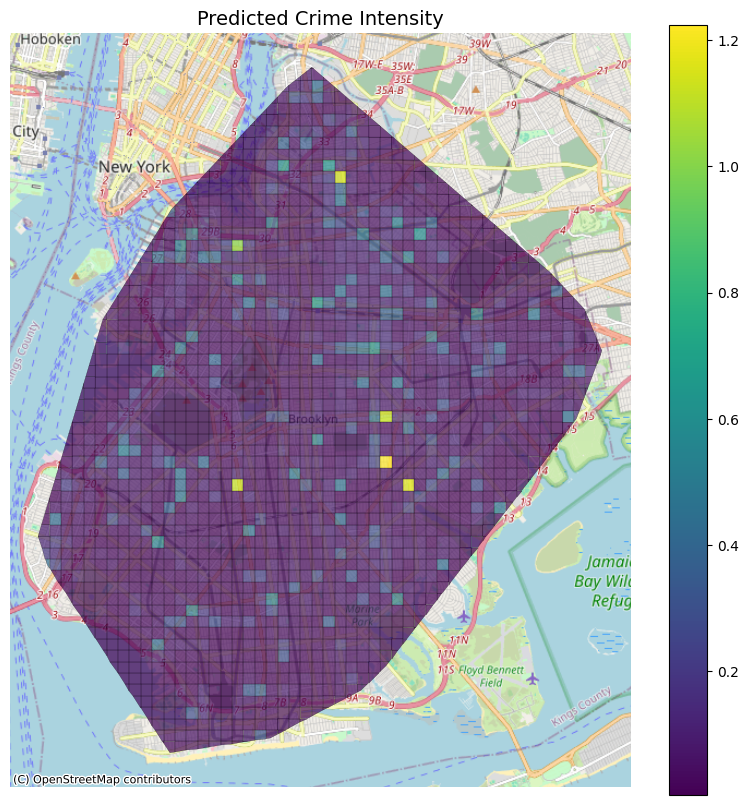

In [109]:
visualize_predictions(region_grid, y_pred_final)